In [1]:
import pandas as pd
import numpy as np

import time

from rdkit import Chem

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Timer

from torch_geometric.nn import GATv2Conv, TransformerConv
from torch_scatter import scatter_mean

from lion_pytorch import Lion

import matplotlib.pyplot as plt


if torch.cuda.is_available():
    print("cuda", torch.cuda.is_available())
    print(torch.cuda.get_device_name(0))
    torch.cuda.empty_cache()
else:
    print("CUDA is not available.")


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pytorch_lightning.trainer.connectors.data_connector")
warnings.filterwarnings("ignore", category=UserWarning, module="lightning_fabric.plugins.environments.slurm")


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from utils.train import MoleculeModel, MoleculeDataModule, get_metric, GATv2Model
from utils.prepare import MoleculeData, MoleculeDataset, FeaturizationParameters

cuda True
NVIDIA GeForce RTX 2080 SUPER


In [2]:
molecule_dataset = torch.load("../../data/QM_137k.pt")

In [3]:
molecule_dataset[0]

Data(x=[31, 333], edge_index=[2, 64], edge_attr=[64, 414], y=[31], smiles='CNC(=S)N/N=C/c1c(O)ccc2ccccc12')

In [4]:
batch_size = 128   
num_workers = 8  

data_module = MoleculeDataModule(molecule_dataset, batch_size=batch_size, num_workers=num_workers)

In [5]:
class TransformerModel(nn.Module):
    def __init__(self, atom_in_features, edge_in_features, hidden_features, out_features, num_heads, dropout_rate, activation_fn):
        super(TransformerModel, self).__init__()

        self.atom_preprocess = nn.Sequential(
            nn.Linear(atom_in_features, hidden_features),
            nn.BatchNorm1d(hidden_features),
            activation_fn,
            nn.Dropout(dropout_rate)
        )

        self.edge_preprocess = nn.Sequential(
            nn.Linear(edge_in_features, hidden_features),
            nn.BatchNorm1d(hidden_features),
            activation_fn,
            nn.Dropout(dropout_rate)
        )

        self.atom_message_layer = nn.Sequential(
            nn.Linear(hidden_features, hidden_features),
            nn.BatchNorm1d(hidden_features),
            activation_fn,
            nn.Dropout(dropout_rate)
        )

        # Первый слой GATv2Conv
        self.trans_conv1 = TransformerConv(
            in_channels=hidden_features * 2,  # Учитываем атомные сообщения
            out_channels=hidden_features,
            heads=num_heads,
            dropout=dropout_rate,
            concat=True
        )

        # Второй слой GATv2Conv
        self.trans_conv2 = TransformerConv(
            in_channels=hidden_features * num_heads,  # Выход с предыдущего слоя GATv2
            out_channels=hidden_features,
            heads=num_heads,
            dropout=dropout_rate,
            concat=True
        )

        self.bn1 = nn.BatchNorm1d(hidden_features * num_heads)
        self.bn2 = nn.BatchNorm1d(hidden_features * num_heads)

        self.activation = activation_fn
        self.dropout = nn.Dropout(dropout_rate)

        # FFN
        self.postprocess = nn.Sequential(
            nn.Linear(hidden_features * num_heads, hidden_features * 2),
            nn.BatchNorm1d(hidden_features * 2),
            activation_fn,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_features * 2, hidden_features),
            nn.BatchNorm1d(hidden_features),
            activation_fn,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_features, out_features)
        )

    def forward(self, x, edge_index, edge_attr):
        atom_features = self.atom_preprocess(x)
        edge_features = self.edge_preprocess(edge_attr)

        row, col = edge_index
        agg_edge_features = scatter_mean(edge_features, col, dim=0, dim_size=x.size(0))
        atom_messages = self.atom_message_layer(atom_features + agg_edge_features)

        combined_features = torch.cat([atom_messages, agg_edge_features], dim=1)

        combined_features = self.trans_conv1(combined_features, edge_index)
        combined_features = self.bn1(combined_features)
        combined_features = self.activation(combined_features)
        combined_features = self.dropout(combined_features)

        combined_features = self.trans_conv2(combined_features, edge_index)
        combined_features = self.bn2(combined_features)
        combined_features = self.activation(combined_features)
        combined_features = self.dropout(combined_features)

        out = self.postprocess(combined_features).squeeze(-1)
        return out


In [6]:
in_features = molecule_dataset[0].x.shape[1]
hidden_features = 64
num_heads = 8

edge_attr_dim = molecule_dataset[0].edge_attr.shape[1]

dropout_rate = 0.0
activation_fn = nn.ReLU()

optimizer_class = Lion 
learning_rate = 0.00085           
weight_decay = 2e-4         

step_size = 50       
gamma = 0.1                     

max_epochs = 100     
patience = 5       

base_model = TransformerModel(
    atom_in_features=in_features,
    hidden_features=hidden_features,
    out_features=1,
    num_heads=num_heads,
    dropout_rate=dropout_rate,
    activation_fn=activation_fn,
    edge_in_features=edge_attr_dim
)


model = MoleculeModel(
    base_model=base_model,
    optimizer_class=optimizer_class,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    step_size=step_size,
    gamma=gamma,
    batch_size=batch_size,
    metric='rmse'
)

print("Model:\n", model)

checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1, verbose=True)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=patience, verbose=True, mode='min')
logger = pl.loggers.CSVLogger('logs', name='GATv2')
timer = Timer()


trainer = pl.Trainer(
    max_epochs=max_epochs,
    enable_checkpointing = False,
    auto_scale_batch_size=True,
    accelerator='auto',
    devices=1,
    callbacks=[early_stop_callback, timer],
    enable_progress_bar=False,
    logger=False
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model:
 MoleculeModel(
  (base_model): TransformerModel(
    (atom_preprocess): Sequential(
      (0): Linear(in_features=333, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.0, inplace=False)
    )
    (edge_preprocess): Sequential(
      (0): Linear(in_features=414, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.0, inplace=False)
    )
    (atom_message_layer): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.0, inplace=False)
    )
    (gat_conv1): TransformerConv(128, 64, heads=8)
    (gat_conv2): TransformerConv(512, 64, heads=8)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

In [7]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | base_model | TransformerModel | 1.4 M 
------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.775     Total estimated model params size (MB)
Metric val_loss improved. New best score: 0.207
Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.207
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.206
Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.204
Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.200
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.199
Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.199
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.198
Monitored metric val_loss did not improve in the last 5 records

In [8]:
print(f"Время обучения: {timer.time_elapsed()} секунд")

Время обучения: 58.90216252300888 секунд


In [9]:
df = trainer.test(model, data_module.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE: 0.1931
MSE: 0.0373
R²: 0.0930
MAE: 0.1188


In [10]:
df_results = model.df_results

all_predictions = np.concatenate(df_results['predictions'].values)
all_true_values = np.concatenate(df_results['true_values'].values)

rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))

print(f"Общий RMSE: {rmse}")

Общий RMSE: 0.19307635724544525


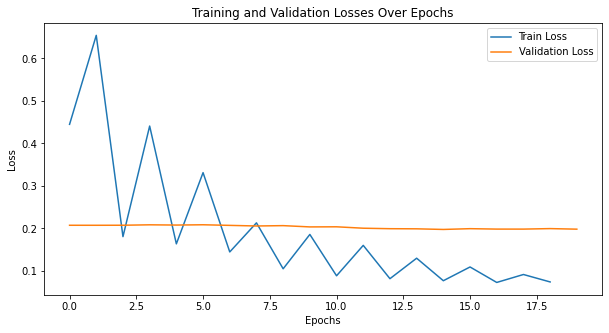

In [11]:
train_losses = model.train_losses
val_losses = model.val_losses

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.show()

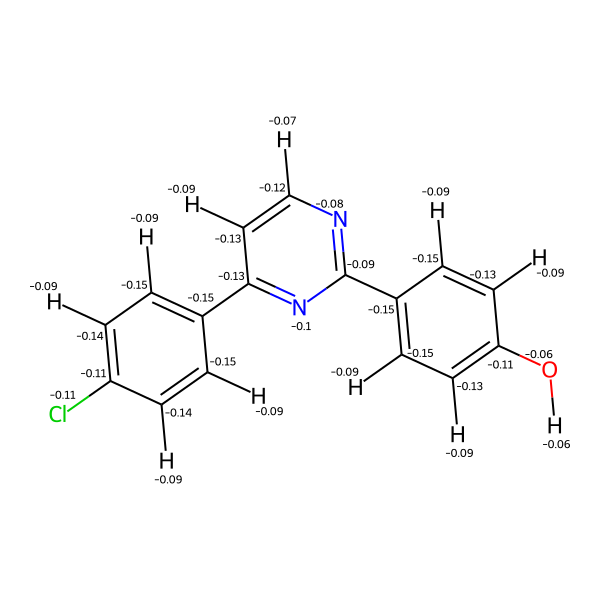

In [12]:
def draw_molecule(smiles, predictions):
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
    predictions_rounded = np.round(predictions, 2)

    for atom, pred in zip(mol.GetAtoms(), predictions_rounded):
        atom.SetProp('atomNote', str(pred))

    img = Chem.Draw.MolToImage(mol, size=(600, 600), kekulize=True)
    img.show()

smiles = df_results.iloc[0]['smiles']
predictions = df_results.iloc[0]['predictions']

draw_molecule(smiles, predictions)


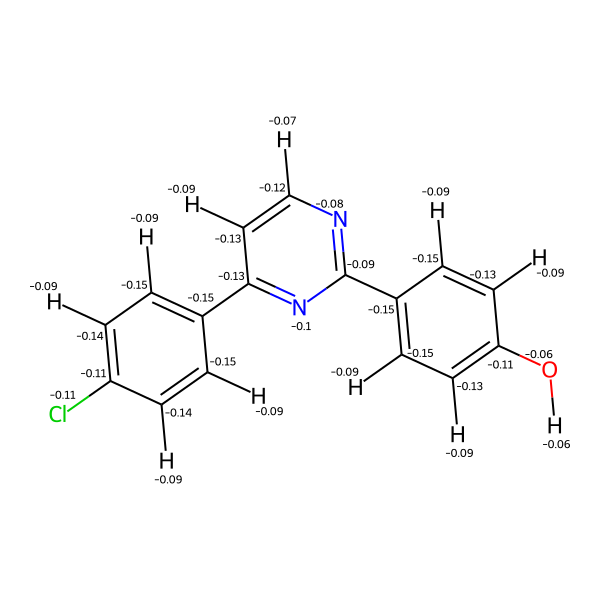

: 

In [13]:
def draw_molecule(smiles, predictions):
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
    predictions_rounded = np.round(predictions, 2)

    for atom, pred in zip(mol.GetAtoms(), predictions_rounded):
        atom.SetProp('atomNote', str(pred))

    img = Chem.Draw.MolToImage(mol, size=(600, 600), kekulize=True)
    img.show()

smiles = df_results.iloc[0]['smiles']
predictions = df_results.iloc[0]['predictions']

draw_molecule(smiles, predictions)
